# Ratings Prediction Project

## Introduction
This project is related a website where people write different reviews for technical products. Now a new feature has been added to website i.e., the reviewer will have to add stars(rating) as well with the review. The rating is out 5 stars and it only has 5 options available 1 star, 2 stars, 3 stars, 4 stars, 5 stars. Now the requirement is to predict ratings for the reviews which were written in the past for which website don’t have a rating. So, we have to build an application which can predict the rating by seeing the review.


## About Dataset
Data has been collected from different e-commerce website(s) and stored in .CSV (Comma Seperated Values) format which consists of 77550 records with 3 features as follows:

* Ratings: Rating of the product i.e., 1, 2, 3, 4, & 5.
* Review_title: Title for the review.
* Review_text: Description of review.


In [1]:
#Importing the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
#suppressing warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import tqdm.notebook as tqdm
import sys, timeit
from IPython.display import display

## Loading the dataset

In [2]:
data = pd.read_csv('Rating_Review_Data.csv',index_col=0)
data

,Review_title,Review_text,Ratings
0,Suitable for School kids,\n If you are a College student or a professi...,2.0 out of 5 stars
1,Misrepresentation on MS Office 2019 license - ...,\n Update after one month usage - MS Office 2...,2.0 out of 5 stars
2,The sold me renewed laptop,\n It’s look like renewed laptop because lapt...,2.0 out of 5 stars
3,Amazon dupes with specification/ battery sucks,\n &nbsp;I had seen the specifications and bo...,2.0 out of 5 stars
4,Display back light issue,\n Display gone with 2 months.. But anyway th...,2.0 out of 5 stars
...,...,...,...
77545,Nice product,good product,4
77546,Awesome,Very good as expected and happy with the purchase,5
77547,Awesome,I love it! No complaint!,5
77548,Nice product,good product,4


#### Remarks:
* There are 77550 records with 3 features present.
* Since, the feature Review_title and Review_text are denoting same thing therefore, these features can be merged to a single feature.

## Data Analysis: Cleaning & Preparation

In [3]:
#copying dataframe to another dataframe object
df = data.copy()

#Merging feature Review_review and Review_text to Review_title
df['review_text'] = df['Review_title'].apply(lambda x: str(x)+" ") + df['Review_text']

#Renaming column Ratings to rating
df.rename(columns={'Ratings':'rating'},inplace=True)

#Dropping feature Review Titles and Review Descriptions as these are already merged into review_text
df.drop(columns=['Review_title','Review_text'],inplace=True)

df.head()

,rating,review_text
0,2.0 out of 5 stars,Suitable for School kids \n If you are a Coll...
1,2.0 out of 5 stars,Misrepresentation on MS Office 2019 license - ...
2,2.0 out of 5 stars,The sold me renewed laptop \n It’s look like ...
3,2.0 out of 5 stars,Amazon dupes with specification/ battery sucks...
4,2.0 out of 5 stars,Display back light issue \n Display gone with...


In [4]:
#checking shape of dataset
df.shape

(77550, 2)

In [5]:
#checking general information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77550 entries, 0 to 77549
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rating       68523 non-null  object
 1   review_text  69465 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [6]:
#checking null values
df.isnull().sum()

rating         9027
review_text    8085
dtype: int64

### Review:
We can see the there are some missing values present in the dataset.

In [7]:
#dropping null values rows
df.dropna(inplace=True)

In [8]:
#checking shape of dataset
print(f"Original Shape: {data.shape}")
print(f"New Shape: {df.shape}")

Original Shape: (77550, 3)
New Shape: (68296, 2)


In [9]:
df['rating'].unique()

array(['2.0 out of 5 stars', '3.0 out of 5 stars', '1.0 out of 5 stars',
       '5.0 out of 5 stars', '4.0 out of 5 stars', '5', '1', '4', '3',
       '2'], dtype=object)

### Remarks:
Looking at these unique values in the target column, we can see that the string entries need to be replaced with the respective numeric values (number of stars).

In [10]:
#incorporating the string object datatype values with numeric star values 
df['rating'] = df['rating'].replace('1.0 out of 5 stars',1)
df['rating'] = df['rating'].replace('2.0 out of 5 stars',2)
df['rating'] = df['rating'].replace('3.0 out of 5 stars',3)
df['rating'] = df['rating'].replace('4.0 out of 5 stars',4)
df['rating'] = df['rating'].replace('5.0 out of 5 stars',5)
df['rating'] = df['rating'].astype('int')
df['rating'].unique()

array([2, 3, 1, 5, 4])

In [11]:
df.head()

,rating,review_text
0,2,Suitable for School kids \n If you are a Coll...
1,2,Misrepresentation on MS Office 2019 license - ...
2,2,The sold me renewed laptop \n It’s look like ...
3,2,Amazon dupes with specification/ battery sucks...
4,2,Display back light issue \n Display gone with...


In [12]:
#converting all the review_text to lowercase
df.review_text = df.review_text.str.lower()

#interpreting first 5 rows
df.head()

,rating,review_text
0,2,suitable for school kids \n if you are a coll...
1,2,misrepresentation on ms office 2019 license - ...
2,2,the sold me renewed laptop \n it’s look like ...
3,2,amazon dupes with specification/ battery sucks...
4,2,display back light issue \n display gone with...


### Remarks:

All the review text has been converted to lowercase.

# Exploratory Data Analysis (EDA) & Visualization

### 1. Univariate Analysis

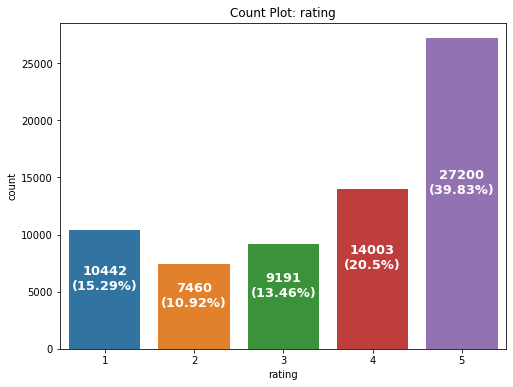

In [13]:
#checking target rating using count plot
x = 'rating'
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.countplot(x=x,data=df,ax=ax)
p=0
for i in ax.patches:
    q = i.get_height()/2
    val = i.get_height()
    ratio = round(val*100/len(df),2)
    prn = f"{val}\n({ratio}%)"
    ax.text(p,q,prn,ha="center",color="white",rotation=0,fontweight="bold",fontsize="13")
    p += 1
    
plt.title("Count Plot: rating")
plt.show()

#### Remarks:

* There are records available for all ratings i.e., from 1 to 5. 
* There are highest number of 5 star ratings followed by 4 star ratings present in the dataset.
* We can see a high 1 star rating as well compared to 2 and 3 star rating reviews

## Checking Distribution of Review text length for each rating using distribution plot:

In [14]:
#adding a new column length for review text length
df['length'] = df.review_text.str.len()

df.head()

,rating,review_text,length
0,2,suitable for school kids \n if you are a coll...,531
1,2,misrepresentation on ms office 2019 license - ...,913
2,2,the sold me renewed laptop \n it’s look like ...,333
3,2,amazon dupes with specification/ battery sucks...,222
4,2,display back light issue \n display gone with...,176


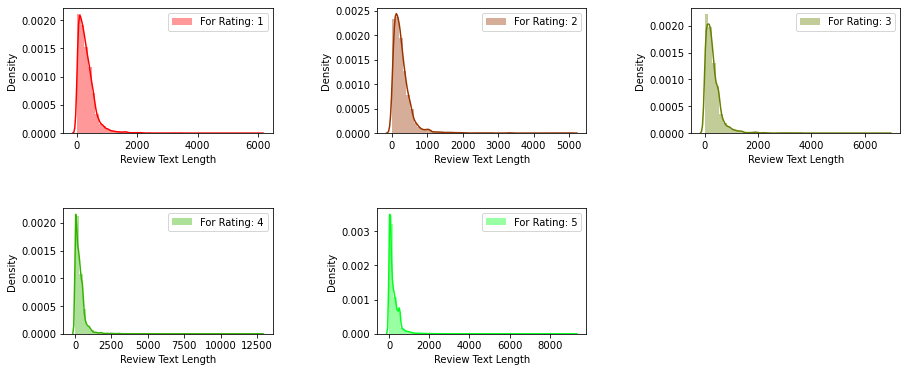

In [15]:
#checking review text length distribution for each rating
ratings = np.sort(df.rating.unique())
cols = 3
rows = len(ratings)//cols
if rows % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(15,6))
plt.subplots_adjust(hspace=0.6, wspace=0.5)
p = 1
colors = [(1,0,0,1),(0.6,0.2,0,1),(0.4,0.5,0,1),(0.2,0.7,0,1),(0,1,0.1,1)]
for i in ratings:
    axis = fig.add_subplot(rows,cols,p)
    sns.distplot(df.length[df.rating==i],ax=axis,label=f"For Rating: {i}",color=colors[i-1])
    axis.set_xlabel(f"Review Text Length")
    axis.legend()
    p += 1
    
plt.show()

### Remarks:

* Rating 1, 3, 5 has almost similar review text length.
* Rating 4 has the highest review text length.
* Rating 2 has the lowest review text length.

## Removing and Replacing certain terms using Regular Expression:

In [16]:
# Replacing money sysmbols with 'dollars' Euro symbol: Alt + 156
df.review_text = df.review_text.str.replace(r'₹|\£|\$','dollars')

# Replacing number with 'numbr'
df.review_text = df.review_text.str.replace(r'\d+(\.\d+)?','numbr')

# Removing punctuation
df.review_text = df.review_text.str.replace(r'[^\w\d\s]',' ')

# Replacing white space between term with single space
df.review_text = df.review_text.str.replace(r'\s+',' ')

# Removing leading and trailing whitespaces
df.review_text = df.review_text.str.replace(r'^\s+|\s+?$','')

In [17]:
df.head()

,rating,review_text,length
0,2,suitable for school kids if you are a college ...,531
1,2,misrepresentation on ms office numbr license i...,913
2,2,the sold me renewed laptop it s look like rene...,333
3,2,amazon dupes with specification battery sucks ...,222
4,2,display back light issue display gone with num...,176


## Removing Stop Words

In [18]:
#setting stop words
stop_words = set(stopwords.words('english') + ['u','ur','ure','im','gd','dont','doin'])

#removing stop words
df.review_text = df.review_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [19]:
#Adding new column clean_length for review_text length after cleaning
df['clean_length'] = df.review_text.str.len()

df.head()

,rating,review_text,length,clean_length
0,2,suitable school kids college student professio...,531,330
1,2,misrepresentation ms office numbr license one ...,913,740
2,2,sold renewed laptop look like renewed laptop l...,333,265
3,2,amazon dupes specification battery sucks nbsp ...,222,152
4,2,display back light issue display gone numbr mo...,176,115


In [20]:
#Checking the difference between original review text length and cleaned length
print(f"Orignal Review Text Length: {df.length.sum()}")
print(f"Cleaned Review Text Length: {df.clean_length.sum()}")
print(f"Difference: {df.length.sum() - df.clean_length.sum()}")

Orignal Review Text Length: 19163989
Cleaned Review Text Length: 13421886
Difference: 5742103


### Remarks:

* Review text length reduced by greater length after removal of stop words and punctuations.

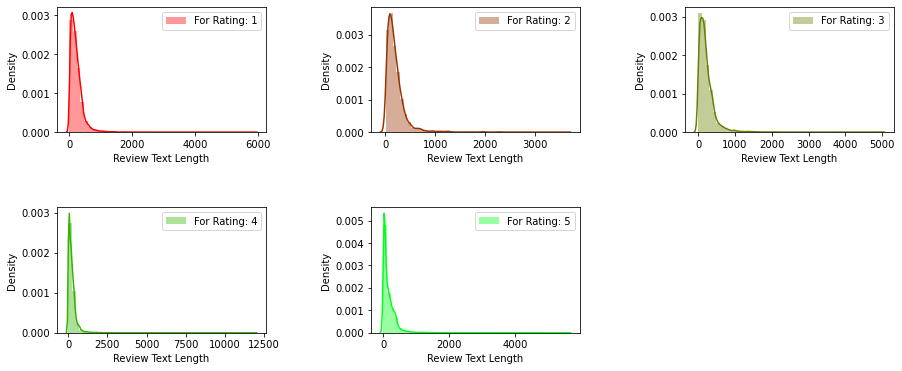

In [21]:
#checking review text length distribution for each rating after cleaning
ratings = np.sort(df.rating.unique())
cols = 3
rows = len(ratings)//cols
if len(ratings) % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(15,6))
plt.subplots_adjust(hspace=0.6, wspace=0.5)
p = 1
colors = [(1,0,0,1),(0.6,0.2,0,1),(0.4,0.5,0,1),(0.2,0.7,0,1),(0,1,0.1,1)]
for i in ratings:
    axis = fig.add_subplot(rows,cols,p)
    sns.distplot(df.clean_length[df.rating==i],ax=axis,label=f"For Rating: {i}",color=colors[i-1])
    axis.set_xlabel(f"Review Text Length")
    axis.legend()
    p += 1

plt.show()

### Remarks:

* Review text length reduced by almost 1000 characters for Rating 1 to 5.

# Displaying with Word Cloud

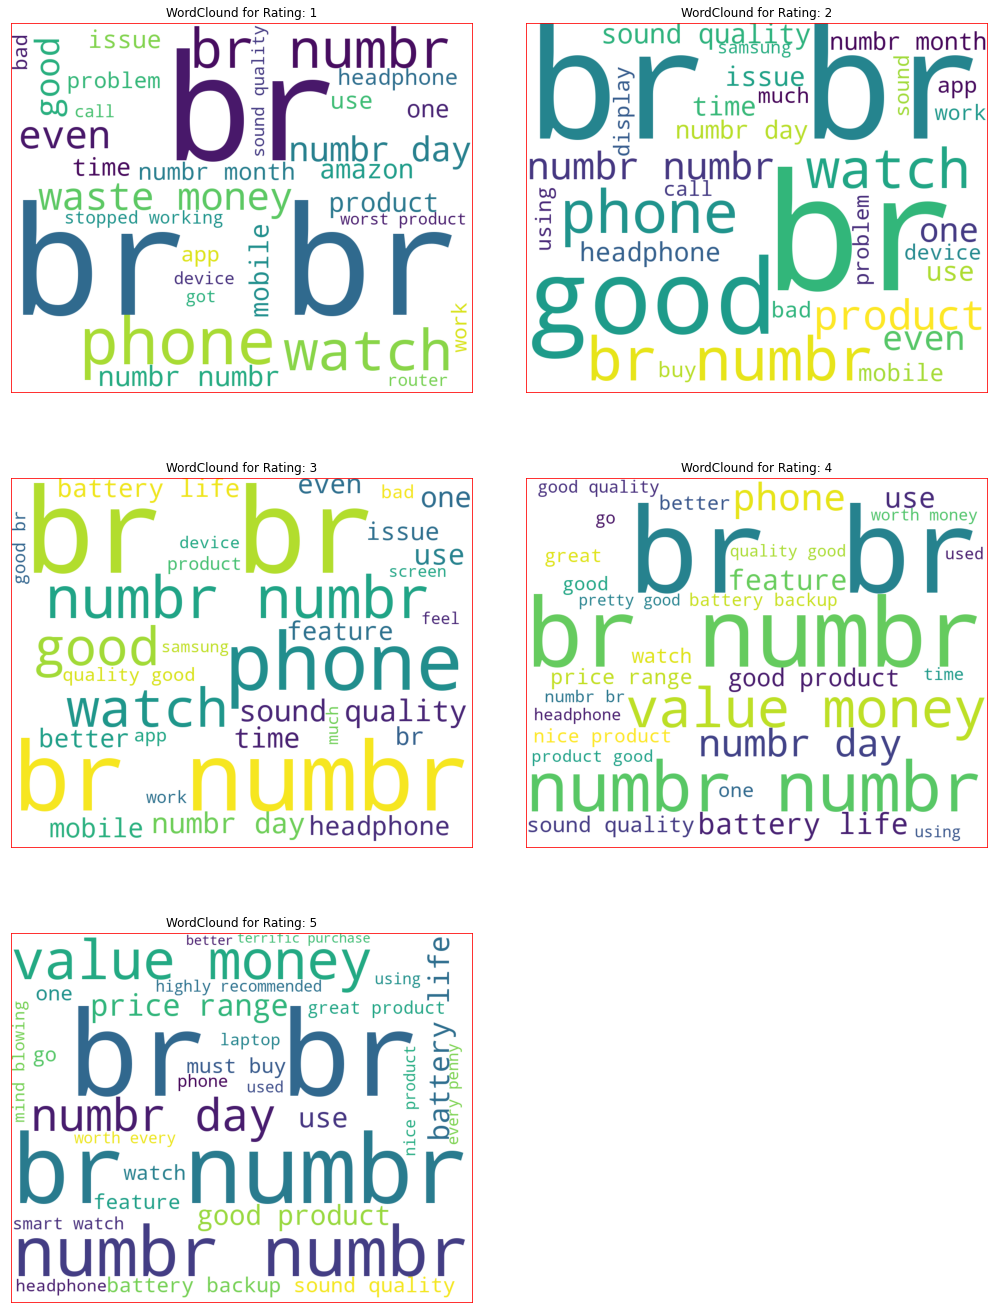

In [22]:
# getting sense of loud word in each rating
cols = 2
rows = len(ratings)//2
if len(ratings) % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.3)
p = 1
for i in ratings:
    word_cloud = WordCloud(height=800, width=1000, background_color="white",max_words=30).generate(' '.join(df.review_text[df.rating==i]))
    axis = fig.add_subplot(rows,cols,p)
    axis.set_title(f"WordClound for Rating: {i}")
    axis.imshow(word_cloud)
    for spine in axis.spines.values():
        spine.set_edgecolor('r')
    axis.set_xticks([])
    axis.set_yticks([])
    
    plt.tight_layout(pad=5)
    p += 1
    
plt.show()

## Remarks:

#### for Rating: 1

It is mostly consists of words like phone, headphone, waste, money, slow, worst, issue etc.

#### for Rating: 2

It is mostly consists of words like phone, good, watch, product, problem, issue, bad etc.

#### for Rating: 3

It is mostly consists of words like phone, good, watch, problem, sound, feature, quality etc.

#### for Rating: 4

It is mostly consists of words like phone, good, value, money, nice product, battery backup, great etc.

#### for Rating: 5

It is mostly consists of words like value, money, must buy, great, perfect, better,terrific purchase, mind blowing etc.

## EDA Concluding Remarks:

* Starting with univariate analysis, with the help of countplot, it was found that the data consists of highest number of 5 star rating followed by 4 star ratings. Moving further with the removal and replacement of certain terms (like, punctuations, extra spaces, numbers, money symbols) as well as removal of stop words, it was evident that the length of review text decreases by a large amount. This was also dipcted by using distribution plot. 


* With the help of wordcloud, it was found that the rating 1 consists of words like phone, headphone, waste, money, slow, worst, issue etc, rating 2 consists of words like problem, issue, bad, etc, rating 3 consists of words like problem, sound, quality etc, rating 4 consists of word like good, value, money, nice, etc. and rating 5 consists of words like must buy, great, perfect, mind blowing etc.

In [24]:
# shuffling the entire data set
df = df.sample(frac=1).reset_index(drop=True)
df

,rating,review_text,length,clean_length
0,5,mind blowing purchase super,27,27
1,5,perfect product love much,36,25
2,5,numbr numbr using product one month love produ...,700,455
3,5,best market nonsense tracker amazing price del...,491,356
4,5,excellent deal price loved watch super amazing...,410,241
...,...,...,...,...
68291,3,use numbr month average phone use numbr month ...,639,485
68292,5,must buy amazing product undoubtedly specially...,309,206
68293,1,flat sounding headphones fan boat products exp...,397,247
68294,4,looks style class nbsp looks awesome battery l...,339,207


In [26]:
# Select data from every Ratings category
df1 = df[df['rating']==1][0:7460]
df2 = df[df['rating']==2][0:7460]
df3 = df[df['rating']==3][0:7460]
df4 = df[df['rating']==4][0:7460]
df5 = df[df['rating']==5][0:7460]

# Combining all the dataframes into one and shuffling them again
df = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df

,rating,review_text,length,clean_length
0,5,classy product perfect one budget bluetooth ca...,525,365
1,5,overall good good go ilike function asks witho...,247,188
2,1,choose better sound much clarity,40,32
3,1,worst product brought product need router coul...,1028,662
4,5,product wirth money paid average product cost ...,219,129
...,...,...,...,...
37295,2,better options available good average br even ...,346,224
37296,5,best market happy,29,17
37297,5,excellent nice looking good phone,42,33
37298,5,excellent product purchased limited deals disc...,223,166


5    7460
1    7460
4    7460
3    7460
2    7460
Name: rating, dtype: int64


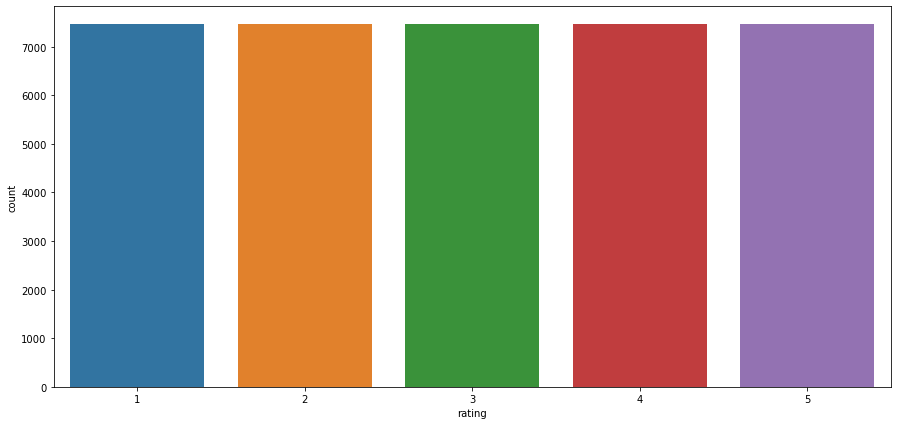

In [27]:
# lets Check the count of target column again to confirm the balance with a visual
plt.figure(figsize=(15,7))
sns.countplot(df['rating'])
print(df.rating.value_counts())
plt.show()

# Preparing Data for Model Training & Testing

In [28]:
#converting text into vectors using TF-IDF
tfidf = TfidfVectorizer()

#vectorizing text features
features = tfidf.fit_transform(df.review_text)

In [29]:
X = features  #Input Variable
Y = df.rating  #Output Variable

In [30]:
#function to get best random state
def get_best_random_state(model,X,Y,t_size=0.25,rs_range=range(1,301,50)):
    best_rstate = 0
    best_accuracy_score = 0
    random_state_message = "\r"
    
    for i in tqdm.tqdm(rs_range,desc=f"Best_Random_State => {model}"):
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=t_size,random_state=i)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        a_score = accuracy_score(Y_test,y_pred)
        
        if a_score > best_accuracy_score:
            best_accuracy_score = a_score
            best_rstate = i
            
        random_state_message += f"[{i}: {round(a_score*100,2)}]<--->"
        sys.stdout.write(random_state_message)
        
    sys.stdout.write(f"\n\nBest Random State: {best_rstate} found with Accuracy: {best_accuracy_score}")
    return best_rstate, best_accuracy_score



#function to get best cv score
def get_best_cv(model,X_train,Y_train,parameters,cv_range=range(5,25,5)):
    best_cv_score = 0
    best_cv = 0
    
    cv_message = "\r"
    for i in tqdm.tqdm(cv_range,desc=f"Best_CV => {model}"):
        gscv = GridSearchCV(model,parameters)
        gscv.fit(X_train,Y_train)
        
        cv_score = cross_val_score(gscv.best_estimator_,X_train,Y_train,cv=i).mean()
        
        if cv_score > best_cv_score:
            best_cv_score = cv_score
            best_cv = i
        
        cv_message += f"[{i}:{round(cv_score*100,2)}]<--->"
        sys.stdout.write(cv_message)
    
    sys.stdout.write(f"\n\nBest CV: {best_cv} found with Cross Val Score: {best_cv_score}")
    
    return best_cv, best_cv_score


#function to build models
def build_models(models,X,Y,t_size=0.25,rs_range=range(1,301,50),cv_range=range(5,25,5)):
    for i in tqdm.tqdm(models,desc="Building Models"):
        sys.stdout.write("\n=======================================================================================\n")
        sys.stdout.write(f"Current Model in Progress: {i} ")
        sys.stdout.write("\n=======================================================================================\n")
        
        #start time
        start_time = timeit.default_timer()
        
        #Find the best random state
        best_random_state, best_accuracy_score = get_best_random_state(models[i]['name'],X,Y,t_size,rs_range)
        sys.stdout.write("\n")
        
        #Spliting train and test data using train_test_split method with best random state value
        X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=t_size,random_state=best_random_state)
        
        #Find the best CV
        best_cv, best_cv_score = get_best_cv(models[i]['name'],X_train,Y_train,models[i]['parameters'],cv_range)
        sys.stdout.write("\n\nBuilding Model...")
        
        #Training the model using best CV
        gscv = GridSearchCV(models[i]['name'],models[i]['parameters'],cv=best_cv)
        gscv.fit(X_train,Y_train)
        
        #Testing model
        y_pred = gscv.best_estimator_.predict(X_test)
        
        #Recording model performance
        model_accuracy_score = accuracy_score(Y_test,y_pred)
        model_confusion_matrix = confusion_matrix(Y_test,y_pred)
        model_classification_report = classification_report(Y_test,y_pred)
        
        #end time
        end_time = timeit.default_timer()
        sys.stdout.write(f"Completed in [{end_time-start_time} sec.]")
        
        #storing model specifications
        models[i]['initial_accuracy_score'] = best_accuracy_score
        models[i]['best_random_state'] = best_random_state
        models[i]['x_train'] = X_train
        models[i]['x_test'] = X_test
        models[i]['y_train'] = Y_train
        models[i]['y_test'] = Y_test
        models[i]['best_cv'] = best_cv
        models[i]['best_cv_score'] = best_cv_score
        models[i]['gscv'] = gscv
        models[i]['y_predict'] = y_pred
        models[i]['final_accuracy'] = model_accuracy_score
        models[i]['confusion_matrix'] = model_confusion_matrix
        models[i]['classification_report'] = model_classification_report
        models[i]['build_time'] = f"{end_time - start_time} (in sec.)"
        
        sys.stdout.write("\n=======================================================================================\n\n\n")
    
    return models


#function to display model performance
def display_performance(models):
    model_names = []
    model_initial_score = []
    model_cross_val_score = []
    model_final_score = []
    model_build_time = []
    for i in models:
        model_names.append(i)
        model_initial_score.append(models[i]['initial_accuracy_score'])
        model_cross_val_score.append(models[i]['best_cv_score'])
        model_final_score.append(models[i]['final_accuracy'])
        model_build_time.append(models[i]['build_time'])
    
    model_df = pd.DataFrame({
        "Name": model_names,
        "Initial Score": model_initial_score,
        "Cross Val Score": model_cross_val_score,
        "Final Score": model_final_score,
        "Build Time": model_build_time,
    })
    
    model_df['Difference (Final Score - Cross Val Score)'] = model_df['Final Score'] - model_df['Cross Val Score']
    display(model_df)
    
    for i in models:
        print("========================================================")
        print(f"for model: {i}")
        print("========================================================")
        print("CLASSIFICATION REPORT")
        print(models[i]['classification_report'])
        print("CONFUSION MATRIX")
        print(models[i]['confusion_matrix'])
        print("=======================================================\n\n")
        
    return


In [31]:
#List of models for training & testing
models = {
    "MultinomialNB":{
        "name": MultinomialNB(),
        "parameters":{
            "alpha": [1.0]                
        }
    },
    "SGDClassifier":{
        "name": SGDClassifier(),
        "parameters":{
            "loss":['hinge','modified_huber'],
            "alpha":[0.001,0.0001,0.00001],
            "n_jobs":[-1],
            "learning_rate":['optimal'],
            "max_iter":[100]
        }
    },
    "KNeighborsClassifier":{
        "name": KNeighborsClassifier(),
        "parameters":{
            "n_neighbors": [5,10],
            "weights": ['uniform','distance'],
            "n_jobs": [-1]
        }
    },
    "DecisionTreeClassifier":{
        "name": DecisionTreeClassifier(),
        "parameters":{
            "criterion": ['gini','entropy'],
            "splitter": ['best','random']
        }
    }
}

In [32]:
#model building
build_model = build_models(models,X,Y)

Building Models:   0%|          | 0/4 [00:00<?, ?it/s]


Current Model in Progress: MultinomialNB 


Best_Random_State => MultinomialNB():   0%|          | 0/6 [00:00<?, ?it/s]

[1: 60.7]<--->[51: 60.3]<--->[101: 60.62]<--->[151: 60.14]<--->[201: 61.9]<--->[251: 60.26]<--->

Best Random State: 201 found with Accuracy: 0.6189812332439678


Best_CV => MultinomialNB():   0%|          | 0/4 [00:00<?, ?it/s]

[5:60.02]<--->[10:60.09]<--->[15:60.16]<--->[20:60.37]<--->

Best CV: 20 found with Cross Val Score: 0.6037171707565491

Building Model...Completed in [5.434509373000083 sec.]



Current Model in Progress: SGDClassifier 


Best_Random_State => SGDClassifier():   0%|          | 0/6 [00:00<?, ?it/s]

[1: 63.02]<--->[51: 62.54]<--->[101: 63.05]<--->[151: 62.76]<--->[201: 62.73]<--->[251: 61.4]<--->

Best Random State: 101 found with Accuracy: 0.630455764075067


Best_CV => SGDClassifier():   0%|          | 0/4 [00:00<?, ?it/s]

[5:64.09]<--->[10:64.35]<--->[15:64.83]<--->[20:64.54]<--->

Best CV: 15 found with Cross Val Score: 0.6482573726541555

Building Model...Completed in [121.64814187600007 sec.]



Current Model in Progress: KNeighborsClassifier 


Best_Random_State => KNeighborsClassifier():   0%|          | 0/6 [00:00<?, ?it/s]

[1: 54.11]<--->[51: 55.24]<--->[101: 54.2]<--->[151: 53.28]<--->[201: 54.51]<--->[251: 53.94]<--->

Best Random State: 51 found with Accuracy: 0.5523860589812333


Best_CV => KNeighborsClassifier():   0%|          | 0/4 [00:00<?, ?it/s]

[5:62.23]<--->[10:63.49]<--->[15:63.89]<--->[20:64.16]<--->

Best CV: 20 found with Cross Val Score: 0.6415725620487145

Building Model...Completed in [1872.012561575 sec.]



Current Model in Progress: DecisionTreeClassifier 


Best_Random_State => DecisionTreeClassifier():   0%|          | 0/6 [00:00<?, ?it/s]

[1: 65.72]<--->[51: 64.34]<--->[101: 65.46]<--->[151: 64.42]<--->[201: 64.76]<--->[251: 64.16]<--->

Best Random State: 1 found with Accuracy: 0.6571581769436997


Best_CV => DecisionTreeClassifier():   0%|          | 0/4 [00:00<?, ?it/s]

[5:62.14]<--->[10:63.26]<--->[15:63.54]<--->[20:63.57]<--->

Best CV: 20 found with Cross Val Score: 0.6357108490532273

Building Model...Completed in [4730.549403769 sec.]




In [33]:
#displaying model performances
display_performance(models)

,Name,Initial Score,Cross Val Score,Final Score,Build Time,Difference (Final Score - Cross Val Score)
0,MultinomialNB,0.618981,0.603717,0.618981,5.434509373000083 (in sec.),0.015264
1,SGDClassifier,0.630456,0.648257,0.650938,121.64814187600007 (in sec.),0.002681
2,KNeighborsClassifier,0.552386,0.641573,0.646863,1872.012561575 (in sec.),0.005291
3,DecisionTreeClassifier,0.657158,0.635711,0.664450,4730.549403769 (in sec.),0.028740


for model: MultinomialNB
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           1       0.68      0.73      0.70      1862
           2       0.55      0.48      0.51      1845
           3       0.49      0.58      0.53      1793
           4       0.62      0.59      0.60      1958
           5       0.78      0.70      0.74      1867

    accuracy                           0.62      9325
   macro avg       0.62      0.62      0.62      9325
weighted avg       0.62      0.62      0.62      9325

CONFUSION MATRIX
[[1366  309  149   27   11]
 [ 424  894  411   85   31]
 [ 158  300 1040  235   60]
 [  51   91  391 1161  264]
 [  24   33  121  378 1311]]


for model: SGDClassifier
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           1       0.69      0.74      0.72      1886
           2       0.56      0.56      0.56      1843
           3       0.59      0.53      0.56      1850
           4       0.62      0.63      0

### Remarks:
> From the above model comparision, it is clear that SGDClassifier performs better with Accuracy Score: 65.09% and Cross Val Score: 64.82% than other models; therefore, we are proceeding with SGDClassifier as our final model.

# Model Saving:

In [36]:
import joblib
#selecting best model
best_model = models['SGDClassifier']

#saving model
joblib.dump(best_model['gscv'].best_estimator_,open('Rating_Review.obj','wb'))

# Conclusion:

In [37]:
model_conclusion = pd.DataFrame({
    "Original": best_model['y_test'],
    "Predicted": best_model['y_predict']
})
model_conclusion

,Original,Predicted
20090,1,2
6875,1,1
25877,5,5
27386,4,4
2504,5,5
...,...,...
18857,4,4
4618,4,4
30708,4,4
34519,1,1


# Pre-processing Pipeline
The following pre-processing pipeline is performed for model prediction:

* Loading the dataset
* Merging feature Review_title and Review_text to review_text
* Dropping columns Review_title and Review_text.
* Treating Null Values by dropping null value rows using pandas dropna() method.
* Converting review_text to lower-case.
* Removing punctuations, leading whitespaces, trailing whitespaces and replace money symbols with 'dollars', numbers with 'numbr', white space between terms with single space.
* Removing Stop Words
* Converting Text into Vectors using TfidfVectorizer
* Building the predictive model.
* Loading the serialized Model
* Predicting Output by using the final model.

### Final Remarks:
I am finishing this project with model SGDClassifier which gives the final accuracy score of 65.09% and cross_val_score: 64.82%. This can be further improved by training with more specific data.